In [1]:
import pandas as pd
from google.colab import files
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
dataset = files.upload()
df = pd.read_csv('Dataset_futebol.csv',';')
df_copia = df.copy()
df.head()

Saving Dataset_futebol.csv to Dataset_futebol.csv


<ipython-input-2-1b100a9c8a13>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('Dataset_futebol.csv',';')


,Unnamed: 0,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,0,Charlton,Man City,4,0,H,2,0,H,17,...,14,4,13,12,6,6,1,2,0,0
1,1,Chelsea,West Ham,4,2,H,1,0,H,17,...,10,5,19,14,7,7,1,2,0,0
2,2,Coventry,Middlesbrough,1,3,A,1,1,D,6,...,3,9,15,21,8,4,5,3,1,0
3,3,Derby,Southampton,2,2,D,1,2,A,6,...,4,6,11,13,5,8,1,1,0,0
4,4,Leeds,Everton,2,0,H,2,0,H,17,...,8,6,21,20,6,4,1,3,0,0


In [3]:
# seleção de atributos
df_selecao = df[['HS', 'AS', 'HST',	'AST', 'HC', 'AC', 'HF', 'AF','HY','AY','HR','FTR']]
df_selecao

,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,FTR
0,17,8,14,4,6,6,13,12,1,2,0,H
1,17,12,10,5,7,7,19,14,1,2,0,H
2,6,16,3,9,8,4,15,21,5,3,1,A
3,6,13,4,6,5,8,11,13,1,1,0,D
4,17,12,8,6,6,4,21,20,1,3,0,H
...,...,...,...,...,...,...,...,...,...,...,...,...
6075,3,9,1,3,8,7,22,18,4,2,0,A
6076,19,11,7,5,5,6,13,15,0,0,0,H
6077,9,5,5,1,5,1,10,14,0,5,1,H
6078,11,8,7,5,7,5,17,10,1,2,0,H


In [6]:
X = df_selecao[['HS', 'AS', 'HST',	'AST', 'HC', 'AC', 'HF', 'AF','HY','AY','HR']].values
y = df_selecao['FTR'].values
y_teste_dummy = pd.get_dummies(y)
df_adh = pd.concat([df_selecao, y_teste_dummy], axis=1)
y = df_adh[['A', 'D', 'H']].values

In [7]:
def func_sigmoidal(x):
    return 1 / (1 + np.exp(-x))

class RedeNeural:
  def __init__(self):
    self.tamanho_entrada = 11
    self.tamanho_escondido = 22 # dobro do input_size
    self.tamanho_saida = 3
    self.pesos_entrada = np.random.randn(self.tamanho_entrada, self.tamanho_escondido)
    self.pesos_oculta = np.random.randn(self.tamanho_escondido, self.tamanho_saida)
    self.momentum = 0.5
    self.taxa_aprendizado = 0.2
    self.epocas = 1000


  def treinar_rede(self, X, y):
    for epoca in range(self.epocas):
      for i in range(len(X)):
            entrada = X[i]
            saida_desejada = y[i]

            somatorio_oculto = np.dot(entrada, self.pesos_entrada)
            saida_oculta = func_sigmoidal(somatorio_oculto)

            somatorio_saida = np.dot(saida_oculta, self.pesos_oculta)
            saida = func_sigmoidal(somatorio_saida)

            erro = saida_desejada - saida

            delta_saida = erro * saida * (1 - saida)
            gradiente_saida = saida_oculta.reshape(-1, 1).dot(delta_saida.reshape(1, -1))

            erro_oculta = delta_saida.dot(self.pesos_oculta.T)
            delta_oculta = erro_oculta * saida_oculta * (1 - saida_oculta)
            gradiente_oculta = entrada.reshape(-1, 1).dot(delta_oculta.reshape(1, -1))


            self.pesos_oculta += self.taxa_aprendizado * gradiente_saida * self.momentum
            self.pesos_entrada += self.taxa_aprendizado * gradiente_oculta * self.momentum


  def prever_jogo(self, HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR):
      entrada = np.array([HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR])
      somatorio_oculta = np.dot(entrada, self.pesos_entrada)
      saida_oculta = func_sigmoidal(somatorio_oculta)
      somatorio_saida = np.dot(saida_oculta, self.pesos_oculta)
      saida = func_sigmoidal(somatorio_saida)

      return saida


  def avaliar_rede(self, X_teste, y_teste):
        previsoes = []

        for entrada in X_teste:
            HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR = entrada
            saida = self.prever_jogo(HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR)
            previsoes.append(saida)


        y_teste = np.array(y_teste)
        previsoes = np.array(previsoes)

        y_teste = y_teste.argmax(axis=1)
        previsoes = previsoes.argmax(axis=1)

        matriz_confusao = confusion_matrix(y_teste, previsoes)
        acuracia = accuracy_score(y_teste, previsoes)
        precisao = precision_score(y_teste, previsoes, average='macro')
        recall = recall_score(y_teste, previsoes, average='macro')
        f1 = f1_score(y_teste, previsoes, average=None)

        print("Acurácia:", acuracia)
        print("Precisão:", precisao)
        print("Recall:", recall)
        print("F1-score:", f1)
        print(matriz_confusao)

        disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=['A', 'D', 'H'])
        disp.plot()

Acurácia: 0.7886513157894737
Precisão: 0.7773575272567522
Recall: 0.7753180297210083
F1-score: [0.77355372 0.72386895 0.83136594]
[[234  36  37]
 [ 21 232  65]
 [ 43  55 493]]


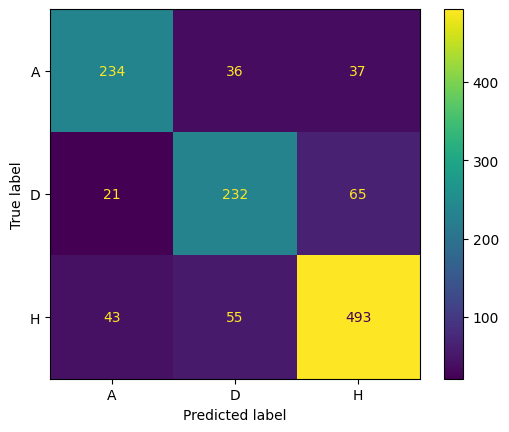

In [8]:
tamanho_treino = int(0.8 * len(X))
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

modelo = RedeNeural()
modelo.treinar_rede(X_treino, y_treino)
modelo.avaliar_rede(X_teste, y_teste)